##  Classification and Visualization


https://en.wikipedia.org/wiki/Multi-label_classification

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys
import copy

import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

from textwrap import wrap
from itertools import compress


In [3]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
import MonaLIA.util.visualization_helpers as vis
import MonaLIA.model.train as model
import MonaLIA.data.image_transforms
import MonaLIA.data.image_dataset

#importlib.reload(MonaLIA.util.visualization_helpers)
importlib.reload(MonaLIA.model.train)
#importlib.reload(MonaLIA.data.image_transforms)
#importlib.reload( MonaLIA.data.image_dataset)
    
from MonaLIA.data import image_transforms
from MonaLIA.data import image_dataset

from MonaLIA.data.image_dataset import JocondeDataset
from MonaLIA.data.binary_subset import BinarySubset
from MonaLIA.data.image_transforms import NormalizeMultiCrop, PadToSquare

from MonaLIA.util.visualization_helpers import target_to_text, prediction_to_text
from MonaLIA.util.visualization_helpers import show_confusion_matrix, show_random_images, image_tensor_to_np
from MonaLIA.util.visualization_helpers import visualize_classification_HTML as display_HTML
from MonaLIA.util.visualization_helpers import compare_classification_HTML as display_compare_HTML

In [4]:
print('PyTorch ver.' ,  torch.__version__ )
print('torchvision ver.' ,  torchvision.__version__ )
print('cuda ver.', torch.version.cuda)
print('sckit-learn ver.', sklearn.__version__)
print('matplotlib ver.', matplotlib.__version__)
print('pandas ver.', pd.__version__)

PyTorch ver. 1.6.0
torchvision ver. 0.7.0
cuda ver. 10.2
sckit-learn ver. 0.23.2
matplotlib ver. 3.3.1
pandas ver. 1.1.1


### Load Data

In [11]:
dataset = 'Joconde'

if dataset == 'Joconde':
    images_root = 'C:/Joconde/joconde'
    descr_path = 'C:/Datasets/Joconde/Forty classes'
    image_description_file = os.path.join(descr_path, 'dataset1.csv')
    exclude_labels = []# ['espèce animale+être humain' , 'none+none'] 

elif dataset == 'ImageNet': # refactor
    images_root = 'Z:\Documents\Python Scripts\data\ImageNet'

else:
    raise ValueError('unknown dataset')


multi_label = True
multi_crop = False
batch_size = 4

model_name = 'inception_v3'
model_checkpoint_file = '../../MonaLIA/output/inception_v3_Joconde_40_classes.test.1000.1.checkpoint.pth.tar'
model_metrics_file = '../../MonaLIA/output/inception_v3_Joconde_40_classes.test.1000.1.csv'

model_image_size = 299

In [13]:
if model_name == 'inception_v3':
    dataset_mean =  [0.5, 0.5, 0.5]
    dataset_std  =  [0.5, 0.5, 0.5]

elif model_name == 'vgg16_bn':
    if dataset == 'Joconde':
        dataset_mean =  image_transforms.joconde_mean_animals 
        dataset_std  =  image_transforms.joconde_std_animals 
    else:
        dataset_mean =  image_transforms.imagenet_mean 
        dataset_std  =  image_transforms.imagenet_std

else:
        dataset_mean =  image_transforms.imagenet_mean 
        dataset_std  =  image_transforms.imagenet_std   
    
if (multi_crop):
    test_trans = transforms.Compose([
                    transforms.Resize(max(256, model_image_size)),
                    transforms.FiveCrop(model_image_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
                    NormalizeMultiCrop(mean = dataset_mean,
                                         std = dataset_std)
                    ])
else:

    test_trans = transforms.Compose([
        #PadToSquare(padding_mode='wrap'),
        #transforms.Resize((model_image_size, model_image_size)), 
        transforms.Resize(model_image_size),
        transforms.CenterCrop(model_image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = dataset_mean,
                             std = dataset_std),
    ])
    

if dataset == 'Joconde':
    test_set = JocondeDataset(image_description_file, 
                            images_root,
                            dataset_name = '40_classes',
                            exclude_labels=exclude_labels  ,
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['test']}, 
                            add_columns=['ref', 'repr'],
                            transform=test_trans)

elif dataset == 'ImageNet':
    test_set = dset.ImageFolder(root=os.path.join(images_root, 'test'),  transform=test_trans)


test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

class_count = len(test_set.classes)
class_names = test_set.classes

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()

Test Dataset JocondeDataset
    Number of datapoints: 4463
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 449
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'ange': 178, 'arbre': 451, 'armure': 85, 'bateau': 300, 'bateau à voiles': 102, 'casque': 63, 'cavalier': 137, 'chapeau': 153, 'cheval': 374, 'chien': 183, 'château': 155, 'couronne': 155, 'croix': 119, 'de face': 237, 'de profil': 317, 'drapeau': 58, 'draperie': 177, 'en buste': 360, 'feuille': 86, 'fleur': 247, 'lion': 64, 'livre': 171, 'main': 127, 'maison': 290, 'mer': 109, 'montagne': 121, 'mouton': 56, 'nu': 277, 'nuage': 52, 'nudité': 123, 'oiseau': 219, 'pont': 112, 'robe': 62, 'table': 82, 

## Adjust if Binary (balanced)

In [73]:
class_count = len(checkpoint['classes'])

if(class_count == 2):

    test_set = BinarySubset(test_set, 'ange')
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

    class_count = len(test_set.classes)
    class_names = test_set.classes

    print('Test', test_set)
    print('    Labels:', test_set.labels_count)
    print()


Test Dataset BinarySubset
    Number of datapoints: 356
    Root location: C:/Joconde/joconde
    Number of classes: 2
    Number of positive labels: 178
    Number of negative labels: 178
    Labels: {'~ange': 178, 'ange': 178}



## Transform to Binary (unbalalnced)

In [22]:
def transform_sample(sample, class_idx):
    sample_list = list(sample)
    sample_list[1] = [sample[1][class_idx] ^ 1 , sample[1][class_idx] ]
    return tuple(sample_list)

def transform_dataset(dataset, subset_class):
    class_idx =  dataset.class_to_idx[subset_class]
    
    dataset.samples = [ transform_sample(sample, class_idx)  for sample in dataset.samples ]
    dataset.targets = [sample[1] for sample in dataset.samples]
    dataset.imgs = dataset.samples

    dataset.classes = ['~' + subset_class, subset_class]
    dataset.class_to_idx = { '~' + subset_class: 0, subset_class: 1}

    labels_per_class = [sum([target[i] for target in dataset.targets]) for i in range(len(dataset.classes))]
    dataset.labels_count = dict(zip(dataset.classes, labels_per_class))
    
    return dataset



In [1073]:
subset_class = checkpoint['classes'][1]
class_idx =  test_set.class_to_idx[subset_class]
print(subset_class, class_idx)

transform_dataset(test_set, subset_class)

print('Test', test_set)
print('    Labels:', test_set.labels_count)
print()

Test Dataset JocondeDataset
    Number of datapoints: 4463
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 2
    Number of uniqie labels: 2
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(299, 299))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
    Labels: {'~ange': 4285, 'ange': 178}



### Read metrics from the cluster run

In [19]:
print(model_checkpoint_file)
checkpoint = torch.load(model_checkpoint_file)
print(checkpoint.keys())

../../MonaLIA/output/inception_v3_Joconde_40_classes.1000.1.checkpoint.pth.tar
dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time'])


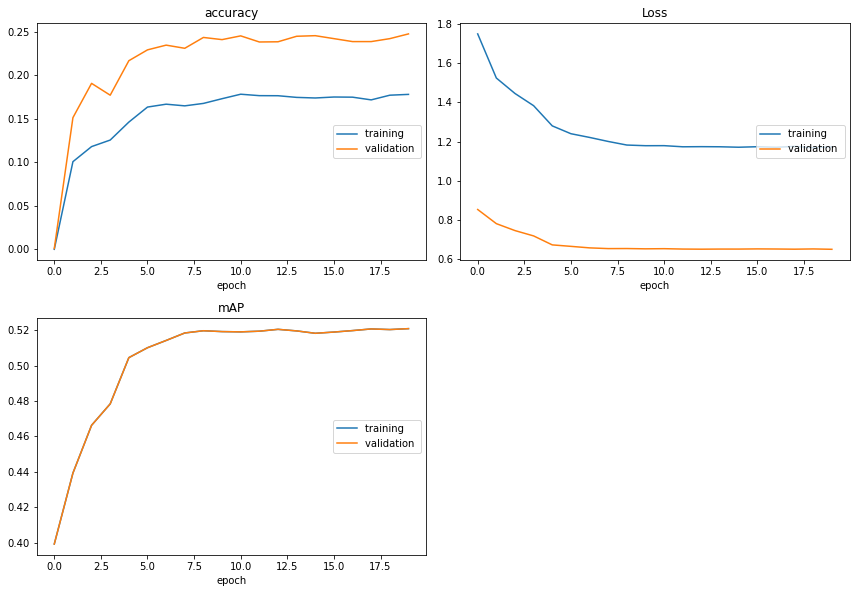

accuracy
	training         	 (min:    0.000, max:    0.178, cur:    0.178)
	validation       	 (min:    0.001, max:    0.248, cur:    0.248)
Loss
	training         	 (min:    1.169, max:    1.749, cur:    1.173)
	validation       	 (min:    0.651, max:    0.854, cur:    0.651)
mAP
	training         	 (min:    0.399, max:    0.521, cur:    0.521)
	validation       	 (min:    0.399, max:    0.521, cur:    0.521)
Best model training accuracy: 0.1782
Best model validation accuracy: 0.2475
Best model mAP: 0.5209
Best model epoch (mAP): 20
Training time: 4:37:25.349032


In [20]:
from livelossplot import PlotLosses

metrics_offset = 0
if os.path.exists(model_metrics_file): 
    metrics_df_old = pd.read_csv(model_metrics_file)
    metrics_df = metrics_df_old
    metrics_offset = 1
else:
    metrics_df = pd.DataFrame(checkpoint['metrics_history'])

liveloss_cluster = PlotLosses()#(max_epoch=metrics_df.shape[0], max_cols=2)

for i, row in metrics_df.iterrows():
    epoch_stats ={}
    for col in metrics_df.columns[metrics_offset:]:#.sort_values(ascending=False):
        epoch_stats[col] = row[col]

    liveloss_cluster.update(epoch_stats)
    
liveloss_cluster.draw()

print('Best model training accuracy: %.4f' % metrics_df.accuracy.max())
print('Best model validation accuracy: %.4f' % metrics_df.val_accuracy.max())
print('Best model mAP: %.4f' % metrics_df.val_mAP.max())
print('Best model epoch (mAP): %d' %  (metrics_df.val_mAP.idxmax() + 1))
print('Training time: %s' % checkpoint['elapsed_time'])


In [21]:
## read training set and validation set for the statistics
train_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['train']})
val_set = JocondeDataset(image_description_file, 
                            images_root,
                            exclude_labels=exclude_labels  ,
                            label_column='label',
                            multiple_labels = multi_label, 
                            filter_dict= {'usage': ['val']})

if(len(checkpoint['classes']) == 2):

    train_set = BinarySubset(train_set, checkpoint['classes'][1])
    
    val_set = BinarySubset(val_set, checkpoint['classes'][1])

    
print(train_set)
print(val_set)

Dataset JocondeDataset
    Number of datapoints: 55990
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 4893
Dataset JocondeDataset
    Number of datapoints: 4463
    Root location: C:/Joconde/joconde
    Description file: C:/Datasets/Joconde/Forty classes\dataset1.csv
    Number of classes: 40
    Number of uniqie labels: 449


### Load Model

In [22]:
if os.path.exists(model_checkpoint_file.replace('checkpoint' , 'best')): 
    print(model_checkpoint_file.replace('checkpoint' , 'best'))
    checkpoint = torch.load(model_checkpoint_file.replace('checkpoint' , 'best'))
else:
    print(model_checkpoint_file)
    checkpoint = torch.load(model_checkpoint_file)
print(checkpoint.keys())
class_count = len(checkpoint['classes'])

../../MonaLIA/output/inception_v3_Joconde_40_classes.1000.1.checkpoint.pth.tar
dict_keys(['epoch', 'arch', 'state_dict', 'best_acc', 'classes', 'threshold', 'elapsed_time'])


In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print('Using cuda? ', use_cuda)

net = model.load_net(model_name = model_name, class_count=class_count)
#net.load_state_dict(torch.load(model_param_file))
net.load_state_dict(checkpoint['state_dict'])
net = net.to(device)
#print(net.transform_input)

Using cuda?  True


### Run Model

In [25]:
th = checkpoint['threshold'].round(2)
print(th)

[0.9  0.85 0.95 0.85 0.95 0.95 0.95 0.9  0.85 0.9  0.95 0.9  0.95 0.95
 0.9  0.95 0.9  0.95 0.95 0.9  0.95 0.9  0.95 0.95 0.95 0.95 0.9  0.95
 0.95 0.95 0.85 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.9 ]


In [26]:
activation = torch.sigmoid
decision = model.decision_by_class_threshold
decision_param = th

In [27]:
scores = model.predict(net, test_loader, activation, decision, decision_param)

images total: 1000, correct: 257, acc: 25.7% , mAP: 0.536
images total: 2000, correct: 514, acc: 25.7% , mAP: 0.530
images total: 3000, correct: 752, acc: 25.1% , mAP: 0.524
images total: 4000, correct: 997, acc: 24.9% , mAP: 0.527
images total: 4463, correct: 1112, acc: 24.9% , mAP: 0.528
Finished prediction


### Statistics

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

In [32]:
scores = scores.cpu() 

decision_param = th#0.4999
print(decision_param)
y_true = np.array(test_set.targets , dtype = np.dtype('B')) 
y_pred = decision(scores, decision_param ).numpy().astype(np.dtype('B'))
#y_pred = model.decision_by_threshold(scores, decision_param).numpy().astype(np.dtype('B'))
y_scores = scores.numpy()

[0.9  0.85 0.95 0.85 0.95 0.95 0.95 0.9  0.85 0.9  0.95 0.9  0.95 0.95
 0.9  0.95 0.9  0.95 0.95 0.9  0.95 0.9  0.95 0.95 0.95 0.95 0.9  0.95
 0.95 0.95 0.85 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.9 ]


In [33]:
prfs = metrics.precision_recall_fscore_support(y_true= y_true,
                                               y_pred= y_pred)

acc = metrics.accuracy_score(y_true= y_true,
                            y_pred= y_pred)


sim = metrics.jaccard_score(y_true= y_true,
                            y_pred= y_pred,
                            average='samples')

mAP = 0.0
mAP =  metrics.average_precision_score(y_true= y_true,
                                       y_score=y_scores,
                                       average='macro')

In [34]:
report = metrics.classification_report(y_true= y_true,
                                 y_pred= y_pred, 
                                 #labels = test_set.classes,
                                 target_names = test_set.classes,
                                 output_dict = True)
ap = 0.0
ap =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average=None)

report_output = pd.concat((pd.Series([x for x in report] ),
                           pd.Series(list(train_set.labels_count.values()) + 4 * [sum(train_set.labels_count.values())]),
                           pd.Series(list(val_set.labels_count.values()) + 4 * [sum(val_set.labels_count.values())]),
                           pd.Series([x['support'] for x in report.values()]),
                           pd.Series([x['recall'] for x in report.values()]).round(3),
                           pd.Series([x['precision'] for x in report.values()]).round(3),
                           pd.Series([x['f1-score'] for x in report.values()]).round(3),
                           pd.Series(ap).round(3),
                           pd.Series(report['macro avg']['f1-score']).round(3),
                           pd.Series(acc).round(3),
                           pd.Series(mAP).round(3),
                           pd.Series(sim).round(3),
                           pd.Series(decision_param)
                           ), axis=1)
report_output.columns = ['class', 'train', 'val', 'test', 'recall', 'precision', 'f1-score', 'AP', 'f1 macroavg','acc', 'mAP', 'jaccard similarity score' , 'param']

pd.options.display.float_format = '{:,.2f}'.format
report_output

C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,train,val,test,recall,precision,f1-score,AP,f1 macroavg,acc,mAP,jaccard similarity score,param
0,ange,2838,178,178,0.58,0.43,0.49,0.49,0.50,0.25,0.53,0.45,0.90
1,arbre,6647,451,451,0.73,0.55,0.62,0.65,nan,nan,nan,nan,0.85
2,armure,1635,85,85,0.62,0.51,0.56,0.59,nan,nan,nan,nan,0.95
3,bateau,4356,300,300,0.81,0.64,0.72,0.80,nan,nan,nan,nan,0.85
4,bateau à voiles,1474,102,102,0.77,0.51,0.61,0.71,nan,nan,nan,nan,0.95
5,casque,1398,63,63,0.29,0.23,0.26,0.23,nan,nan,nan,nan,0.95
6,cavalier,2059,137,137,0.51,0.45,0.48,0.42,nan,nan,nan,nan,0.95
7,chapeau,2395,153,153,0.63,0.43,0.52,0.56,nan,nan,nan,nan,0.90
8,cheval,5511,374,374,0.78,0.59,0.67,0.73,nan,nan,nan,nan,0.85
9,chien,2978,183,183,0.41,0.37,0.39,0.40,nan,nan,nan,nan,0.90


### Visualize 

In [28]:
cat_dd = widgets.Dropdown(options= test_set.classes,
                         description='Categories:')

query_options = [ 'NO EXACT MATCH',
                  'NO INTERSECTION MATCH',
                  '<50% INTERSECTION',
                  '>=50% INTERSECTION',
                  'INTERSECTION MATCH',
                  'EXACT MATCH', 
                  'ALL CONTAINING CLASS',
                  'FALSE POSITIVES'
                ]

opt_ss = widgets.RadioButtons(options = query_options,
                             description = 'Query options',
                             value = '>=50% INTERSECTION'  ,
                                layout=widgets.Layout(width='50%'))
display (cat_dd, opt_ss)

Dropdown(description='Categories:', options=('ange', 'arbre', 'armure', 'bateau', 'bateau à voiles', 'casque',…

RadioButtons(description='Query options', index=3, layout=Layout(width='50%'), options=('NO EXACT MATCH', 'NO …

In [35]:
query = opt_ss.index
item_count = 5
is_random = False
show_class =  test_set.class_to_idx[cat_dd.value] 

>=50% INTERSECTION
2305 of 4463
proportion: 0.52
66 of 2305 containing "chien"


image,crop,labels,prediction
,,"[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chienscène historique (intérieur, banquet,Henri IV, roi de France, homme, femme,aiguière, chien)50170001610C:\Joconde\joconde\0598\m501702_0005113_p.jpg",[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]table : 0.970chien : 0.936chapeau : 0.897robe : 0.830oiseau : 0.815livre : 0.707fleur : 0.599maison : 0.598château : 0.587bateau : 0.576
,,"[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chienscène (chasse à courre : homme, cerf,dépouille, chien, curée)M0810002824C:\Joconde\joconde\0439\m081005_028217_p.jpg",[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chien : 0.992cheval : 0.860cavalier : 0.823mouton : 0.620oiseau : 0.313voiture à attelage : 0.262chapeau : 0.238arbre : 0.237de face : 0.231montagne : 0.092
,,"[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chevalchienscène (soldat, chien, femme, assis,debout, cheval, arme, tambour,végétation, chaumière)02110007025C:\Joconde\joconde\0700\m021102_0003858_p.jpg",[0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]chien : 0.987cheval : 0.983cavalier : 0.981voiture à attelage : 0.794arbre : 0.725oiseau : 0.614mouton : 0.602nuage : 0.380chapeau : 0.361pont : 0.360
,,"[0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]arbrechevalchienscène (départ, chasseur, cheval, chien); paysage (route, feuillu) ; vase000PE003675C:\Joconde\joconde\0337\m503604_p0002785-001_p.jpg",[0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]chien : 0.953arbre : 0.940mouton : 0.936cavalier : 0.930cheval : 0.867château : 0.865montagne : 0.838pont : 0.808maison : 0.783voiture à attelage : 0.750
,,"[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]arbrechienscène (Paris, cadre urbain, parc,jardin, foule, promenade, vêtement,arbre, végétal, bassin d'eau, jet d'eau,autocar, chien)01720017706C:\Joconde\joconde\0666\m017204_0010462_p.jpg",[0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]arbre : 0.932montagne : 0.930maison : 0.930chien : 0.929cavalier : 0.901fleur : 0.887cheval : 0.870table : 0.821voiture à attelage : 0.770oiseau : 0.754

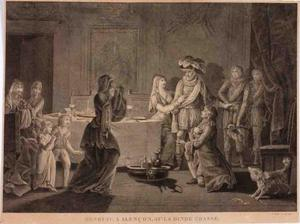
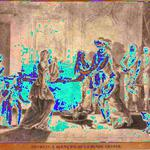
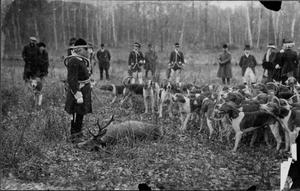
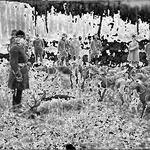
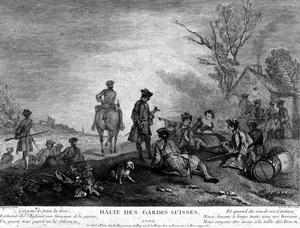
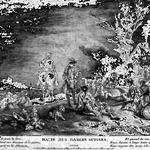
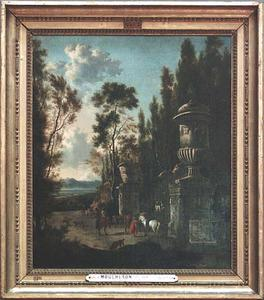
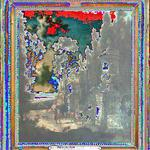
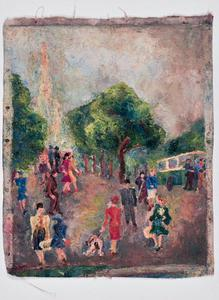
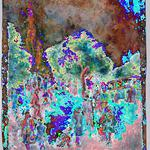

In [36]:
if query == 0:
    #strict accuracy = exact match = subset accuracy
    classified_idx = np.nonzero((y_true == y_pred).sum(axis=1) < class_count)[0]
elif query == 5:
    classified_idx = np.nonzero((y_true == y_pred).sum(axis=1) == class_count)[0]

elif query == 1:    
    #no intersection
    classified_idx = np.nonzero((y_true & y_pred).sum(axis=1) == 0)[0]
elif query == 4:   
    #at least one intersection 
    classified_idx = np.nonzero((y_true & y_pred).sum(axis=1) > 0)[0]

elif query == 2:   
    #intersection "less than" accuracy
    classified_idx = np.nonzero( (y_true & y_pred).sum(axis=1) / y_true.sum(axis=1) < 0.5 )[0]
elif query == 3:   
    classified_idx = np.nonzero( (y_true & y_pred).sum(axis=1) / y_true.sum(axis=1) >= 1.0 )[0]

elif query == 6:
    classified_idx = np.nonzero(y_true.sum(axis=1) >0 )[0] # fudging the full list
    
elif query == 7:    
    classified_idx = np.nonzero( (y_true.astype('int') - y_pred.astype('int')).min(axis=1) < 0)[0]

else:
    raise ValueError('Invalid query')
   
print(query_options[query])

print(classified_idx.shape[0], 'of', y_pred.shape[0] )
print('proportion: %.2f' % (classified_idx.shape[0] / y_pred.shape[0]))

#filter specific class
if show_class >= 0:
    class_filter = np.nonzero(y_true[:, show_class] == 1)[0] if query != 7 else np.nonzero( (y_pred[:, show_class] - y_true[:, show_class]) == 1)[0] 
    n = classified_idx.shape[0]
    classified_idx = np.intersect1d(classified_idx , class_filter)
    print('%d of %d containing "%s"' % (classified_idx.shape[0], n, test_set.classes[show_class] ))

if is_random:
    pick = np.random.randint(0, len(classified_idx), size=item_count)
else:
    pick = np.arange(item_count)

testset_idx_pick = classified_idx[pick]


#visualizer(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10)
HTML(display_HTML(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10))



### Output to HTML file

In [67]:
HTML(display_HTML(test_set, y_pred, y_scores, testset_idx_pick, show_max_pred_labels=10, file_name='lions_binary.softmax.FP.html'))

<IPython.core.display.HTML object>

### Output to csv file

In [370]:

df = pd.DataFrame(columns= ['reference' , 'repr', 'imageFile', 'image', 'label', 'prediction'])

df.reference = [test_set.samples[i][2] for i in testset_idx_pick]
df.repr = [test_set.samples[i][3] for i in testset_idx_pick]
df.imageFile = [test_set.samples[i][0].replace('/', '\\') for i in testset_idx_pick]

df.label = [target_to_text(test_set.classes,test_set.samples[i][1], separator=' | ') for i in testset_idx_pick]    
df.prediction = [prediction_to_text(test_set.classes, scores[i] , separator=' | ') for i in testset_idx_pick]

df.to_csv('lions_multilabel.20.csv', encoding='utf8', sep='\t')
#df

### Scores Distribution

(array([ 5.,  6., 12., 31., 26., 42., 44., 47., 59., 38.]),
 array([0.8568116 , 0.87107223, 0.8853329 , 0.89959353, 0.9138542 ,
        0.9281149 , 0.94237554, 0.9566362 , 0.97089684, 0.9851575 ,
        0.99941814], dtype=float32),
 <BarContainer object of 10 artists>)

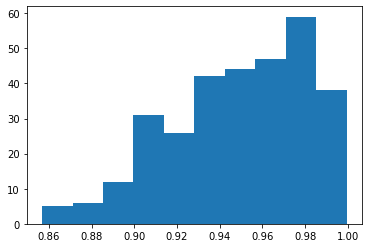

In [39]:
classified_scores = scores[classified_idx].numpy() * y_pred[classified_idx]
classified_scores = classified_scores.flatten()
classified_scores = classified_scores[classified_scores.nonzero()]
plt.hist(classified_scores)

### Confusion Matrix

In [ ]:
from MonaLIA.util.visualization_helpers import show_confusion_matrix
from MonaLIA.util.visualization_helpers import target_to_text, prediction_to_text

#y_true = np.array(test_set.targets)
#y_pred = decision(scores[:,1:], decision_param).numpy()

tick_labels= test_loader.dataset.classes

if(multi_label):
    y_true_text = [target_to_text(test_loader.dataset.classes, list(x), separator='+') for x in y_true]
    y_pred_text = [target_to_text(test_loader.dataset.classes, list(x), separator='+') for x in y_pred]
    tick_labels = sorted(set(y_true_text).union(y_pred_text))
    
show_confusion_matrix(y_true_text, y_pred_text, test_loader.dataset.classes)

## Precision-Recall curve

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [38]:
import ipywidgets as widgets
dd = widgets.Dropdown(
       options= test_set.classes,
       value=test_set.classes[0],
       description='Category:')
dd

Dropdown(description='Category:', options=('ange', 'arbre', 'armure', 'bateau', 'bateau à voiles', 'casque', '…

Text(0.5, 1.0, 'MAISON Precision-Recall curve: AP=0.61')

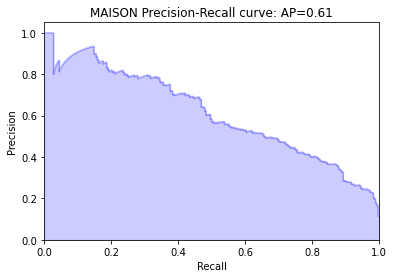

In [39]:
c = test_set.class_to_idx[dd.value]


y_true_c = y_true.take([c], axis=1).ravel()
y_score_c = y_scores.take([c], axis=1).ravel()

average_precision = metrics.average_precision_score(y_true_c, y_score_c)
precision, recall, _ = metrics.precision_recall_curve( y_true_c, y_score_c)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('{0} Precision-Recall curve: AP={1:0.2f}'.format(test_set.classes[c].upper(),
          average_precision))

### Correlation between number of the training labels and the Average Precision

In [40]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = np.array(list(train_set.labels_count.values())).reshape(-1,1)#[:-1]
y = ap#[:-1]

reg = LinearRegression().fit(X, y)
reg.score(X, y)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     11.58
Date:                Wed, 09 Dec 2020   Prob (F-statistic):            0.00158
Time:                        20:36:36   Log-Likelihood:                 18.775
No. Observations:                  40   AIC:                            -33.55
Df Residuals:                      38   BIC:                            -30.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3656      0.054      6.827      0.0

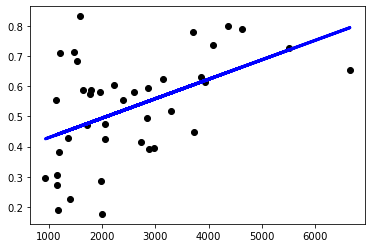

In [41]:
y_pred = reg.predict(X)
plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)
plt.show()

In [42]:
covariance = np.cov(X.squeeze(), y)
covariance

array([[1.73e+06, 1.11e+02],
       [1.11e+02, 3.06e-02]])

In [43]:
from scipy.stats import pearsonr, spearmanr
corr, _ = pearsonr(X.squeeze(), y)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr, _ = spearmanr(X.squeeze(), y)
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.483
Spearmans correlation: 0.483


## Aggregated Binary Ensemble Model Test

In [23]:
net_b = model.load_net(model_name = model_name, class_count=2)

model_checkpoint_file = 'output/Inception_v3_Joconde_40_classes.%s.1000.4.checkpoint.pth.tar'

output = pd.DataFrame(columns= ['class', 'test', 'recall', 'precision', 'f1-score', 'AP', 'f1 macroavg','acc', 'mAP', 'sim', 'threshold','time'])

pcut_threshold = True
if pcut_threshold:
    th_dict = dict(zip(checkpoint['classes'], checkpoint['threshold'].round(2)))
else:
    th_dict = dict(zip(checkpoint['classes'], [0.5] * len(checkpoint['classes'])))

ref = [s[2] for s in test_set.samples]
scores_df = pd.DataFrame(index= ref, columns=test_set.classes)

for clss in test_set.classes:
    #cls_subset = BinarySubset(test_set, clss) #for small balance datasets
    cls_subset = transform_dataset(copy.deepcopy(test_set), clss)
    
    subset_loader = torch.utils.data.DataLoader(dataset=cls_subset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)
    
    check_point_file = model_checkpoint_file % clss
    checkpoint = torch.load(check_point_file)

    print(clss , len(subset_loader.dataset)//2, check_point_file)

    net_b.load_state_dict(checkpoint['state_dict'])
    
    sc = model.predict(net_b, subset_loader, torch.softmax, model.decision_by_threshold, th_dict[clss])
    
    
    sc = sc.cpu()
    

    y_tr = np.array(cls_subset.targets , dtype = np.dtype('B')) 
    y_pr = model.decision_by_threshold(sc, th_dict[clss]).numpy().astype(np.dtype('B'))
    y_sc = sc.numpy()
    
    prec, rec, fs, sup = metrics.precision_recall_fscore_support(y_true= y_tr, y_pred= y_pr)

    acc = metrics.accuracy_score(y_true= y_tr,  y_pred= y_pr)

    sim = metrics.jaccard_score(y_true= y_tr, y_pred= y_pr, average='samples')

    mAP =  metrics.average_precision_score(y_true= y_tr, y_score=y_sc, average='macro')
    
    ap =  metrics.average_precision_score(y_true= y_tr, y_score=y_sc, average=None)
    
    output = output.append({'class': clss,
                   'test': sup[1],
                   'recall': rec[1],
                   'precision': prec[1],
                   'f1-score': fs[1],
                   'AP': ap[1],
                   'f1 macroavg': np.average(fs), 
                   'acc': acc,
                   'mAP': mAP,
                   'sim': sim,
                   'threshold': th_dict[clss],
                   'time': checkpoint['elapsed_time']}, ignore_index=True)
    
    #scores_df.loc [[s[2] for s in cls_subset.samples if s[1][1] == 1], clss] = sc.chunk(2)[0][:,1]
        
    #sc_full = model.score(net_b, test_loader, torch.sigmoid, print_frequency=2000)
    #scores_df.loc [:, clss] = sc_full.cpu()[:,1]
    
    scores_df.loc[:, clss] = y_sc[:, 1]

scores_df.fillna(0.0, inplace = True)

pd.options.display.float_format = '{:,.2f}'.format
output

ange 2231 output/Inception_v3_Joconde_40_classes.ange.1000.4.checkpoint.pth.tar
images total: 1000, correct: 774, acc: 77.4% , mAP: 0.674
images total: 2000, correct: 1587, acc: 79.4% , mAP: 0.697
images total: 3000, correct: 2386, acc: 79.5% , mAP: 0.706
images total: 4000, correct: 3189, acc: 79.7% , mAP: 0.712
images total: 4463, correct: 3562, acc: 79.8% , mAP: 0.715
Finished prediction
arbre 2231 output/Inception_v3_Joconde_40_classes.arbre.1000.4.checkpoint.pth.tar
images total: 1000, correct: 814, acc: 81.4% , mAP: 0.837
images total: 2000, correct: 1606, acc: 80.3% , mAP: 0.832
images total: 3000, correct: 2356, acc: 78.5% , mAP: 0.800
images total: 4000, correct: 3143, acc: 78.6% , mAP: 0.800
images total: 4463, correct: 3500, acc: 78.4% , mAP: 0.800
Finished prediction
armure 2231 output/Inception_v3_Joconde_40_classes.armure.1000.4.checkpoint.pth.tar
images total: 1000, correct: 691, acc: 69.1% , mAP: 0.585
images total: 2000, correct: 1447, acc: 72.4% , mAP: 0.651
images to

images total: 3000, correct: 1978, acc: 65.9% , mAP: 0.577
images total: 4000, correct: 2614, acc: 65.4% , mAP: 0.596
images total: 4463, correct: 2920, acc: 65.4% , mAP: 0.596
Finished prediction
livre 2231 output/Inception_v3_Joconde_40_classes.livre.1000.4.checkpoint.pth.tar
images total: 1000, correct: 688, acc: 68.8% , mAP: 0.685
images total: 2000, correct: 1393, acc: 69.7% , mAP: 0.675
images total: 3000, correct: 2145, acc: 71.5% , mAP: 0.666
images total: 4000, correct: 2867, acc: 71.7% , mAP: 0.676
images total: 4463, correct: 3203, acc: 71.8% , mAP: 0.683
Finished prediction
main 2231 output/Inception_v3_Joconde_40_classes.main.1000.4.checkpoint.pth.tar
images total: 1000, correct: 746, acc: 74.6% , mAP: 0.737
images total: 2000, correct: 1469, acc: 73.5% , mAP: 0.793
images total: 3000, correct: 2207, acc: 73.6% , mAP: 0.786
images total: 4000, correct: 2976, acc: 74.4% , mAP: 0.800
images total: 4463, correct: 3337, acc: 74.8% , mAP: 0.803
Finished prediction
maison 2231 o

,class,test,recall,precision,f1-score,AP,f1 macroavg,acc,mAP,sim,threshold,time
0,ange,178,0.71,0.28,0.40,0.44,0.64,0.80,0.72,0.80,0.90,0 days 00:18:12.558233
1,arbre,451,0.81,0.44,0.57,0.61,0.72,0.78,0.80,0.78,0.85,0 days 00:39:52.051447
2,armure,85,0.73,0.15,0.25,0.36,0.55,0.73,0.68,0.73,0.95,0 days 00:10:10.324816
3,bateau,300,0.85,0.47,0.60,0.75,0.76,0.84,0.87,0.84,0.85,0 days 00:25:53.974303
4,bateau à voiles,102,0.83,0.26,0.40,0.52,0.65,0.81,0.76,0.81,0.95,0 days 00:09:21.454639
5,casque,63,0.65,0.08,0.14,0.11,0.46,0.64,0.55,0.64,0.95,0 days 00:08:37.107826
6,cavalier,137,0.74,0.27,0.39,0.41,0.62,0.74,0.70,0.74,0.95,0 days 00:12:39.054719
7,chapeau,153,0.81,0.19,0.30,0.44,0.55,0.67,0.72,0.67,0.90,0 days 00:14:22.479199
8,cheval,374,0.83,0.45,0.59,0.70,0.74,0.80,0.85,0.80,0.85,0 days 00:32:28.325234
9,chien,183,0.63,0.18,0.28,0.36,0.56,0.71,0.68,0.71,0.90,0 days 00:17:53.556928


In [31]:
y_scores_b = scores_df.to_numpy()
#y_pred_b = model.decision_by_threshold(torch.Tensor(y_scores_b), 0.5).numpy().astype(np.dtype('B'))
y_pred_b = model.decision_by_class_threshold(torch.Tensor(y_scores_b), th).numpy().astype(np.dtype('B'))

image,labels,prediction1,prediction2
,"[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]bateaubateau à voilesmerpaysage (bateau à voiles, mer, ciel,personnage, marin pêcheur)07200000399C:\Joconde\joconde\0357\m072004_0001197_p.jpg",[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]bateau : 0.999bateau à voiles : 0.999mer : 0.982drapeau : 0.804nuage : 0.648tour : 0.423maison : 0.340église : 0.222montagne : 0.204oiseau : 0.197,[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]bateau : 1.000bateau à voiles : 1.000mer : 0.999draperie : 0.852drapeau : 0.469maison : 0.191tour : 0.084nuage : 0.041église : 0.012mouton : 0.011
,"[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]maisonvue d'architecture (Angers, ville, rue,maison)07480018381C:\Joconde\joconde\0590\m074801_0012653_p.jpg",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]maison : 0.991église : 0.909château : 0.692tour : 0.488arbre : 0.238voiture à attelage : 0.194pont : 0.075cheval : 0.046chien : 0.023drapeau : 0.021,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]maison : 1.000voiture à attelage : 0.996château : 0.993église : 0.927pont : 0.832tour : 0.758drapeau : 0.250arbre : 0.125uniforme : 0.008cheval : 0.002
,"[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]de facedraperienufigure (femme : nu, couché sur le dos,de face, draperie)000DE015662C:\Joconde\joconde\0446\m504401_d4783_p.jpg",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]nu : 0.959draperie : 0.881de profil : 0.842de face : 0.837nudité : 0.787main : 0.776ange : 0.195à mi-corps : 0.163oiseau : 0.062en buste : 0.057,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]draperie : 1.000nu : 1.000de face : 0.999de profil : 0.844main : 0.788nudité : 0.684ange : 0.117robe : 0.017à mi-corps : 0.008oiseau : 0.007

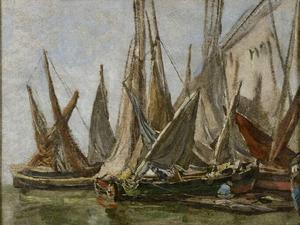
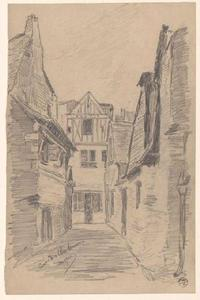
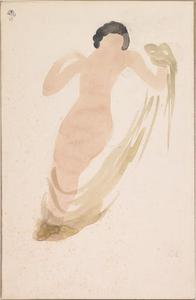

In [32]:
#testset_idx_pick = np.random.randint(0, len(test_set.samples), size=4) 
#testset_idx_pic = np.arange(100)
testset_idx_pick = [3834, 2335, 320]

HTML(display_compare_HTML(test_set,
                          y_pred, y_scores,
                          y_pred_b, y_scores_b,
                          testset_idx_pick, show_max_pred_labels=10))

### Save to HTML

In [ ]:
HTML(display_compare_HTML(test_set,
                          y_pred, y_scores,
                          y_pred_b, y_scores_b, 
                          np.arange(4463), show_max_pred_labels=10, file_name='40 class classification comparision.0.5.html'))

## Scrapbook